In [1]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
def rot_x(theta):
    rot_x = sp.Matrix([[1,0,0],
                       [0,sp.cos(theta),-sp.sin(theta)],
                       [0,sp.sin(theta),sp.cos(theta)]])
    return rot_x

def rot_y(theta):
    rot_y = sp.Matrix([[sp.cos(theta),0,sp.sin(theta)],
                       [0,1,0],
                       [-sp.sin(theta),0,sp.cos(theta)]])
    return rot_y

def rot_z(theta):
    rot_z = sp.Matrix([[sp.cos(theta),-sp.sin(theta),0],
                       [sp.sin(theta),sp.cos(theta),0],
                       [0,0,1]])
    return rot_z

def trans(a,b,c):
    x = sp.Matrix([[a],[b],[c]])
    return x

def get_torque_from_L(L,q,qd):
    round_L_round_q = sp.zeros(len(q),1);
    i = 0;
    for q_i in q:
        round_L_round_q_i = [];
        round_L_round_q_i = sp.diff(L,q_i);
        round_L_round_q[i] = round_L_round_q_i;
        i+=1;
     
    d_dt_round_L_round_qd = sp.zeros(len(qd),1);
    i = 0;
    for qd_i in qd:
        round_L_round_qd_i = [];
        d_dt_round_L_round_qd_i = [];
        round_L_round_qd_i = sp.diff(L,qd_i);
        d_dt_round_L_round_qd_i = time_derivative(round_L_round_qd_i,N);
        d_dt_round_L_round_qd[i] = d_dt_round_L_round_qd_i;
        i+=1;
        
    tau = d_dt_round_L_round_qd - round_L_round_q 
    return tau

In [3]:
r, L_1, l_t = sp.symbols('r, L_1, l_t')
m_w, m_b, m_1, g = sp.symbols('m_w, m_b, m_1, g')
I_w, I_b, I_1 = sp.symbols('I_w, I_b, I_1')
theta_P, theta_w = dynamicsymbols('theta_P, theta_w')

# Displacement Vector
x_c = trans(r*theta_w,0,0)
x_w = x_c +  trans(0,0,r)
x_1 = x_w +  rot_y(theta_P) @ trans(0,0,L_1)
x_b = x_w +  rot_y(theta_P) @ trans(0,0,l_t)


# Velocity Vector
v_w = sp.simplify(time_derivative(x_w,N))
v_b = sp.simplify(time_derivative(x_b,N))
v_1 = sp.simplify(time_derivative(x_1,N))

# Angular Velocity Vector
w_w = trans(0, theta_w.diff(), 0)
w_b = trans(0, theta_P.diff(), 0)
w_1 = trans(0, theta_P.diff(), 0)


# Generalized Coordinates
q = sp.Matrix([[theta_P], [theta_w]])
qd = q.diff()
qdd = qd.diff()

# Kinetic Energy
T_trans = 0.5*(m_w*v_w.dot(v_w) + m_b*v_b.dot(v_b) + m_1*v_1.dot(v_1))
#T_body = I_by * w_b[1]**2 
#T_wheel = I_wy * w_w[1]**2

T_body = I_b* w_b[1]**2 
T_wheel =I_w* w_w[1]**2 
T_1 =I_1* w_1[1]**2 
#T_motor = I_my * n**2 * (theta_w.diff() - theta_P.diff())**2
#T_gimbal_right = I_lfx * w_lf[0]**2 + I_lfy * w_lf[1]**2 + I_lfz * theta_gb.diff()**2
#T_gimbal_left = I_rfx * w_rf[0]**2 + I_rfy * w_rf[1]**2 + I_rfz * theta_gb.diff()**2
T_rot = 0.5*(T_body + T_wheel + T_1 )

#T_rot = 0.5*(I_wy*w_w[1]**2 + I_by*w_b[1]**2 + I_my*n*n*(theta_w.diff()**2) + I_lfz*w_lf[2]**2 + I_rfz*w_rf[2]**2 + I_lfy*w_lf[1]**2 + I_rfy*w_rf[1]**2)
#I_my*n*n*(theta_w.diff()-theta_P.diff())**2,  I_bx*(theta_R.diff()-theta_gb.diff())**2
# Potential Energy
V =  m_b*g*(l_t*sp.cos(theta_P)) + m_1*g*(L_1*sp.cos(theta_P)) 

# Lagrangian
L = T_trans + T_rot - V


In [4]:
tau = get_torque_from_L(L,q,qd)
tau = sp.simplify(tau)
# Ml, Cl, Gl, Wl = ir.get_EoM_from_T(tau,qdd,g)
# Ml, Cl, Gl, Wl

In [5]:
tau

Matrix([
[                       1.0*I_1*Derivative(theta_P(t), (t, 2)) + 1.0*I_b*Derivative(theta_P(t), (t, 2)) + 1.0*L_1**2*m_1*Derivative(theta_P(t), (t, 2)) - 1.0*L_1*g*m_1*sin(theta_P(t)) + 1.0*L_1*m_1*r*cos(theta_P(t))*Derivative(theta_w(t), (t, 2)) - 1.0*g*l_t*m_b*sin(theta_P(t)) + 1.0*l_t**2*m_b*Derivative(theta_P(t), (t, 2)) + 1.0*l_t*m_b*r*cos(theta_P(t))*Derivative(theta_w(t), (t, 2))],
[1.0*I_w*Derivative(theta_w(t), (t, 2)) + 1.0*m_1*r*(-L_1*sin(theta_P(t))*Derivative(theta_P(t), t)**2 + L_1*cos(theta_P(t))*Derivative(theta_P(t), (t, 2)) + r*Derivative(theta_w(t), (t, 2))) + 1.0*m_b*r*(-l_t*sin(theta_P(t))*Derivative(theta_P(t), t)**2 + l_t*cos(theta_P(t))*Derivative(theta_P(t), (t, 2)) + r*Derivative(theta_w(t), (t, 2))) + 1.0*m_w*r**2*Derivative(theta_w(t), (t, 2))]])

In [6]:
T_w, F_b = sp.symbols('T_w, F_b')
u = sp.Matrix([[T_w], [F_b]])

u_matrix = sp.Matrix([[T_w - F_b*l_t*sp.cos(theta_P)], [-T_w - F_b*r]])

In [7]:
tau_eq = tau+u_matrix

In [8]:
M, C, G, W = get_EoM_from_T(tau_eq,qdd,g, u)

In [9]:
M

Matrix([
[1.0*I_1 + 1.0*I_b + 1.0*L_1**2*m_1 + 1.0*l_t**2*m_b,            1.0*r*(L_1*m_1 + l_t*m_b)*cos(theta_P(t))],
[          1.0*r*(L_1*m_1 + l_t*m_b)*cos(theta_P(t)), 1.0*I_w + 1.0*m_1*r**2 + 1.0*m_b*r**2 + 1.0*m_w*r**2]])

In [10]:
C

Matrix([
[                                                                      0],
[-1.0*r*(L_1*m_1 + l_t*m_b)*sin(theta_P(t))*Derivative(theta_P(t), t)**2]])

In [11]:
G

Matrix([
[-1.0*g*(L_1*m_1 + l_t*m_b)*sin(theta_P(t))],
[                                         0]])

In [12]:
W

Matrix([
[-1, l_t*cos(theta_P(t))],
[ 1,                   r]])

In [13]:
linearlize_eq = {sp.sin(theta_P):theta_P, sp.cos(theta_P):1, theta_P.diff()**2:0}
tau_linear = sp.simplify(tau_eq.subs(linearlize_eq))
tau_linear

Matrix([
[-1.0*F_b*l_t + 1.0*I_1*Derivative(theta_P(t), (t, 2)) + 1.0*I_b*Derivative(theta_P(t), (t, 2)) + 1.0*L_1**2*m_1*Derivative(theta_P(t), (t, 2)) - 1.0*L_1*g*m_1*theta_P(t) + 1.0*L_1*m_1*r*Derivative(theta_w(t), (t, 2)) + 1.0*T_w - 1.0*g*l_t*m_b*theta_P(t) + 1.0*l_t**2*m_b*Derivative(theta_P(t), (t, 2)) + 1.0*l_t*m_b*r*Derivative(theta_w(t), (t, 2))],
[                                                                                 -F_b*r + 1.0*I_w*Derivative(theta_w(t), (t, 2)) - T_w + 1.0*m_1*r*(L_1*Derivative(theta_P(t), (t, 2)) + r*Derivative(theta_w(t), (t, 2))) + 1.0*m_b*r*(l_t*Derivative(theta_P(t), (t, 2)) + r*Derivative(theta_w(t), (t, 2))) + 1.0*m_w*r**2*Derivative(theta_w(t), (t, 2))]])

In [14]:
Ml, Cl, Gl, Wl = get_EoM_from_T(tau_linear,qdd,g, u)

In [15]:
Ml

Matrix([
[1.0*I_1 + 1.0*I_b + 1.0*L_1**2*m_1 + 1.0*l_t**2*m_b,                            1.0*r*(L_1*m_1 + l_t*m_b)],
[                          1.0*r*(L_1*m_1 + l_t*m_b), 1.0*I_w + 1.0*m_1*r**2 + 1.0*m_b*r**2 + 1.0*m_w*r**2]])

In [16]:
Cl

Matrix([
[0],
[0]])

In [17]:
Gl

Matrix([
[-1.0*g*(L_1*m_1 + l_t*m_b)*theta_P(t)],
[                                    0]])

In [18]:
Wl

Matrix([
[-1.0, 1.0*l_t],
[   1,       r]])

In [19]:
m1 = 2.486 + 0.3
m2 = 1.416
m3 = 1.739
m4 = 3.25+12.5

m2+m3+m4

18.905

In [20]:
param = {I_1: 0.007514491, I_w:0.004806909, I_b:2.089539709502296,  m_b:18.905,  m_1:2.786,  m_w:2.292, r:0.069, L_1: 0.171, l_t:1.022142,  g:9.81}

Mlp = msubs(Ml, param)
Clp = msubs(Cl, param)
Glp = msubs(Gl, param)
Wlp = msubs(Wl, param)

Mlp_inv = Mlp.inv()
qdd_rhs_A = Mlp_inv*(-Clp -Glp)
qdd_rhs_B = Mlp_inv*Wlp*u

X = q.col_join(qd)
Xd_A = qd.col_join(qdd_rhs_A)
Xd_B = qd.col_join(qdd_rhs_B)
U = u

A = Xd_A.jacobian(X)
B = Xd_B.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)

ss0 = [A, B, C, D]
sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
mprint(sys0)

A = [[   0.            0.            1.            0.        ]
     [   0.            0.            0.            1.        ]
     [  31.10913995    0.            0.            0.        ]
     [-357.183949      0.            0.            0.        ]]

B = [[ 0.          0.        ]
     [ 0.          0.        ]
     [-1.99905826  0.03682218]
     [31.35653708  0.15710182]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]



In [21]:
Q = sp.Matrix([ [1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1] ])
R = sp.Matrix([ [0.01,0],
             [0,0.01] ])

K, S, E = control.lqr(sys0.A, sys0.B, Q, R)


In [22]:
sysc = sys0.feedback(K)
sysc;

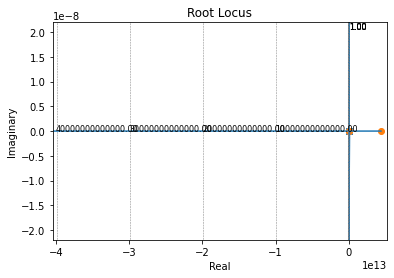

In [23]:
control.rlocus(sysc);

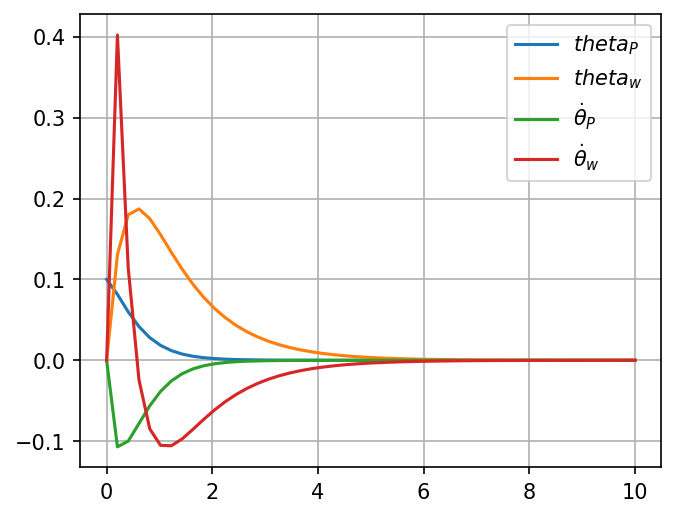

In [24]:
x0 = [0.1, 0, 0, 0]
u = 0
dt = 0.01
tf = 10

t, y = control.forced_response(sysc, X0=x0, T=pl.linspace(0,tf), transpose=True)

plt.figure(1, figsize=(5,4), dpi=150)
plt.plot(t, y);
plt.legend([r'$theta_P$',r'$theta_w$',r'$\dot\theta_P$',r'$\dot\theta_w$'], loc='best')
plt.grid()

In [25]:
# Rough 한 조건식
vmax_ = 5/3.6
t_ = 20# sec

target_pos = vmax_*t_
v = vmax_/target_pos
a = v/4
a

0.012499999999999999

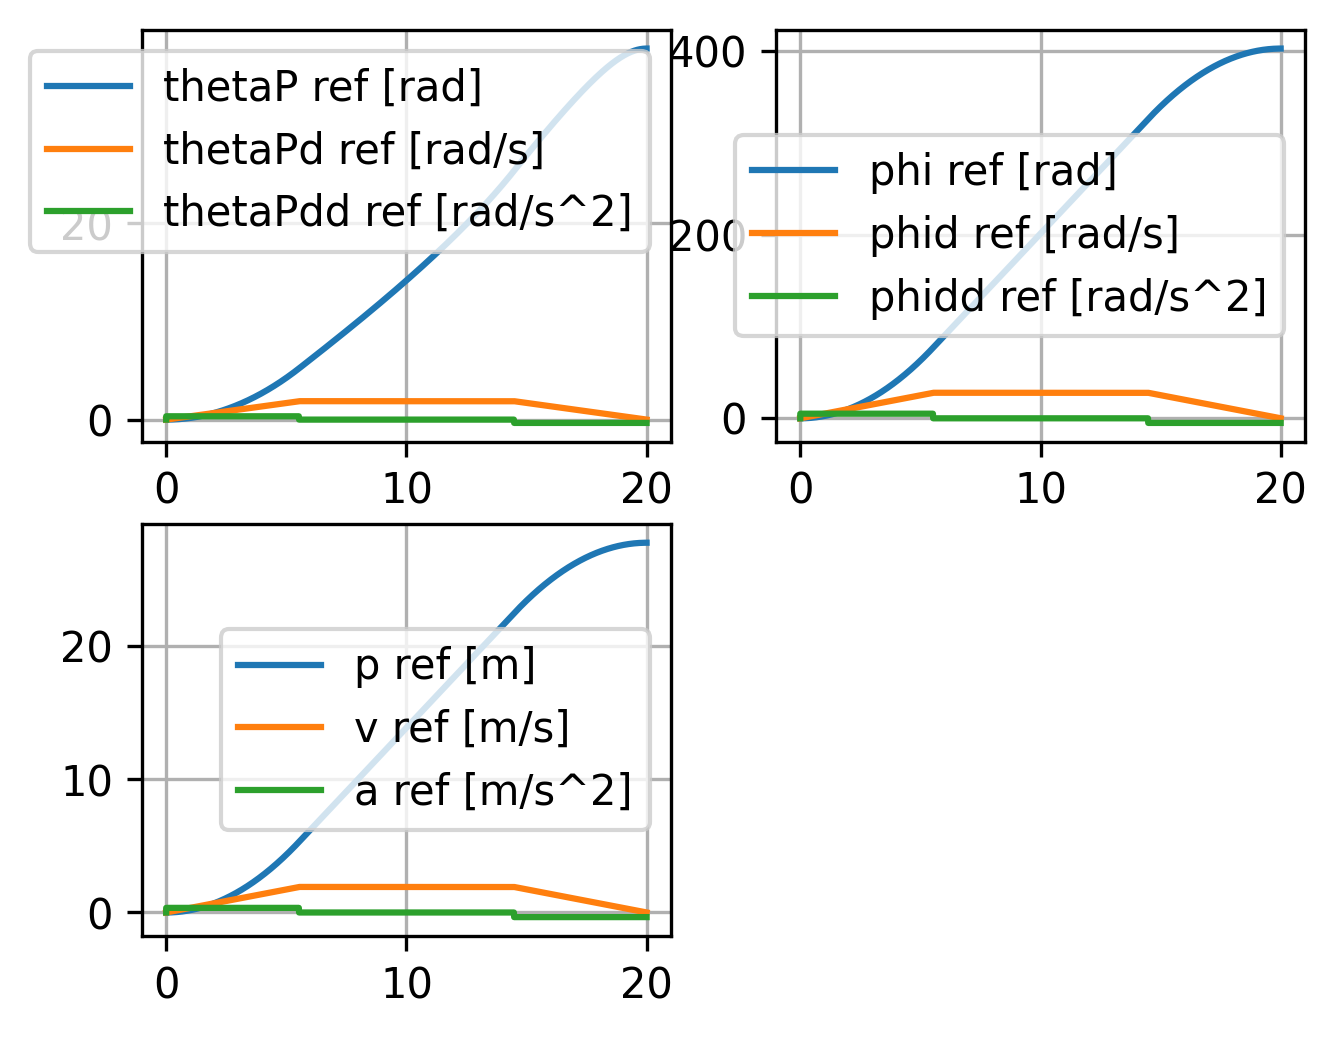

In [26]:
t_s, traj_s = ir.Trapezoidal_Traj_Gen_Given_Amax_and_T(a,t_,0.01)

l_t = 1.022142
thetaP_traj = np.arcsin(traj_s/l_t)
phi_traj = traj_s/ 0.069

rad2deg = 180/np.pi
pl.figure(1, figsize=(5,4), dpi=300)

pl.subplot(221);
pl.plot(t_s, thetaP_traj*target_pos);
pl.legend(['thetaP ref [rad]', 'thetaPd ref [rad/s]', 'thetaPdd ref [rad/s^2]'], loc='best');
pl.grid()

pl.subplot(222);
pl.plot(t_s, phi_traj*target_pos)
pl.legend(['phi ref [rad]', 'phid ref [rad/s]', 'phidd ref [rad/s^2]'], loc='best')
pl.grid()

pl.subplot(223);
pl.plot(t_s, traj_s*target_pos)
pl.legend(['p ref [m]', 'v ref [m/s]', 'a ref [m/s^2]'], loc='best')
pl.grid()

In [27]:
thetaP_traj[:,0]

array([0.00000000e+00, 0.00000000e+00, 6.11461030e-07, ...,
       1.36224628e+00, 1.36226105e+00, 1.36226991e+00])

In [28]:

thetaP_des = thetaP_traj[:,2]*target_pos
thetaw_des = phi_traj[:,0]*target_pos
thetawd_des = phi_traj[:,1]*target_pos
thetaPdot_des = thetaP_traj[:,1]*target_pos

zeros = np.zeros(len(thetaP_traj))
thetaPdes = thetaP_des
thetaPdes = np.vstack((thetaPdes, thetaw_des)) 
thetaPdes = np.vstack((thetaPdes, zeros))
thetaPdes = np.vstack((thetaPdes, thetawd_des))

thetaPdes.shape, thetaPdes

((4, 2001),
 array([[ 0.00000000e+00,  3.39709040e-01,  3.39709040e-01, ...,
         -3.39709040e-01, -3.39709040e-01, -3.39709040e-01],
        [ 0.00000000e+00,  0.00000000e+00,  2.51610306e-04, ...,
          4.02574225e+02,  4.02575483e+02,  4.02576238e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  5.03220612e-02, ...,
          1.50966184e-01,  1.00644122e-01,  5.03220612e-02]]))

In [29]:
thetaPdes

array([[ 0.00000000e+00,  3.39709040e-01,  3.39709040e-01, ...,
        -3.39709040e-01, -3.39709040e-01, -3.39709040e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.51610306e-04, ...,
         4.02574225e+02,  4.02575483e+02,  4.02576238e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.03220612e-02, ...,
         1.50966184e-01,  1.00644122e-01,  5.03220612e-02]])

In [30]:
thetaPdes[0:3,]

array([[ 0.00000000e+00,  3.39709040e-01,  3.39709040e-01, ...,
        -3.39709040e-01, -3.39709040e-01, -3.39709040e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.51610306e-04, ...,
         4.02574225e+02,  4.02575483e+02,  4.02576238e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [31]:
K[0][0:]

array([-108.88419031,    8.41326556,  -34.06434548,    7.89736439])

In [44]:
Q = sp.Matrix([ [1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1] ])
R = sp.Matrix([ [0.07,0],
                [0,0.07] ])

K, S, E = control.lqr(sys0.A, sys0.B, Q, R)
K

array([[-1.84124180e+02,  1.02102986e+00, -5.98318624e+01,
         7.82178505e-02],
       [ 2.26227057e+02,  3.63912247e+00,  7.83188538e+01,
         4.92315527e+00]])

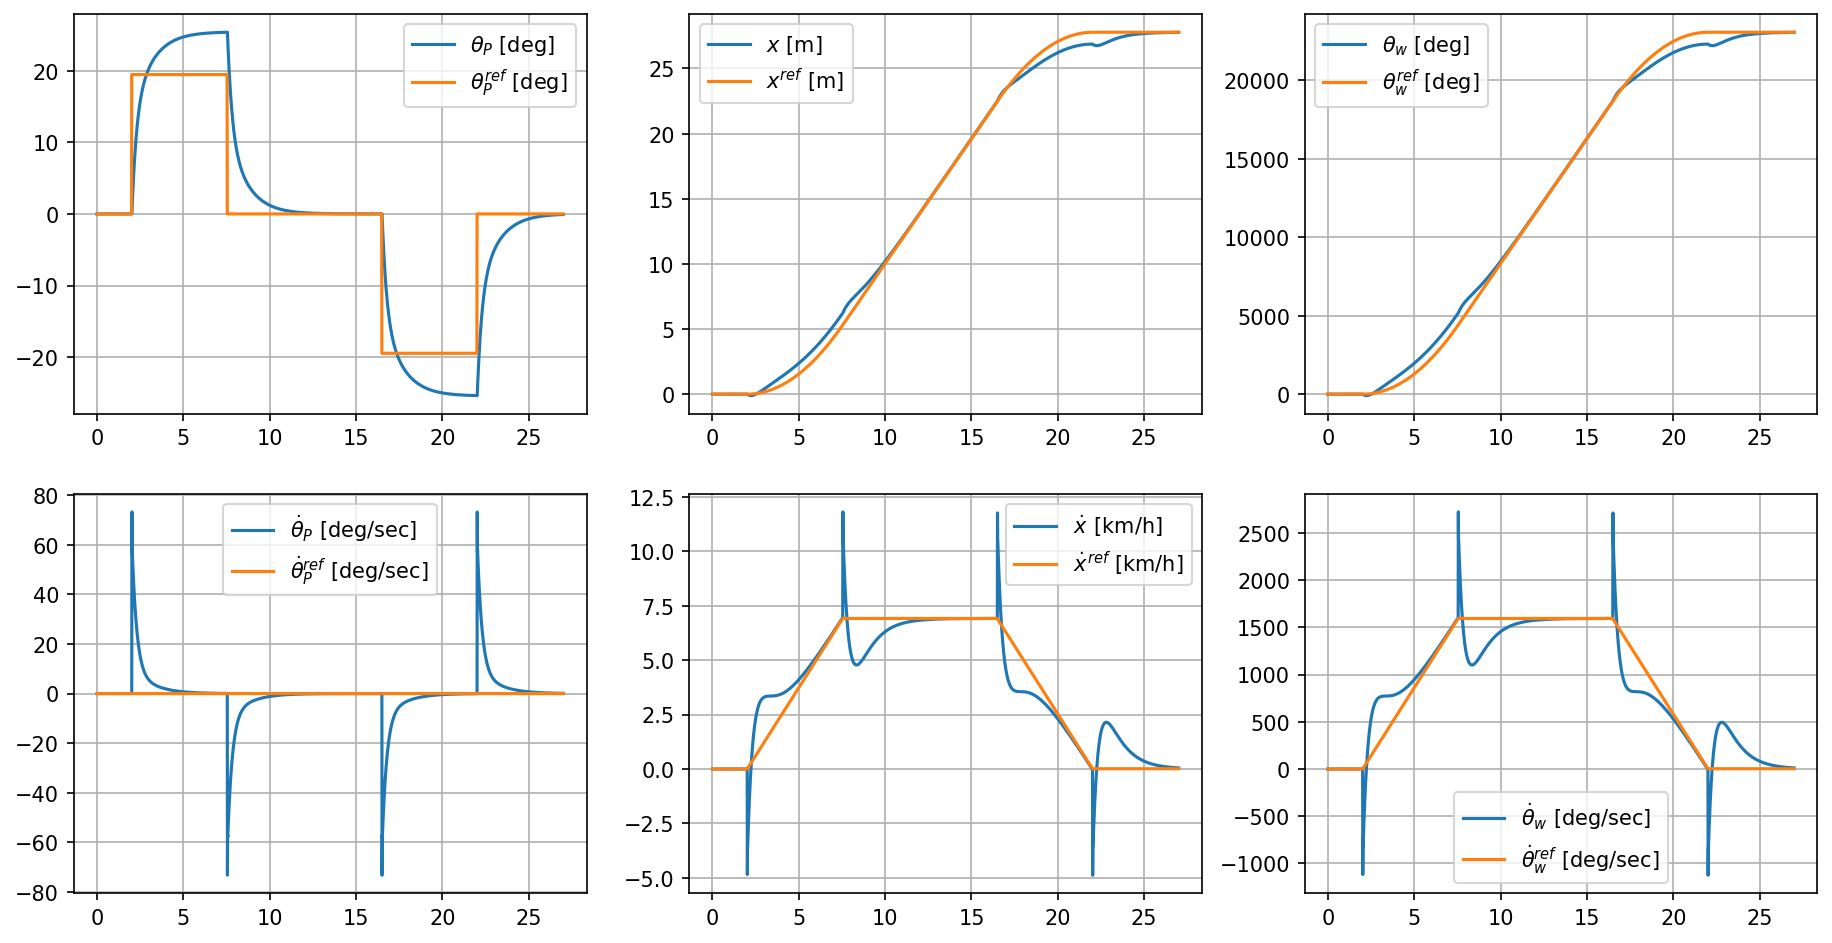

In [45]:
# Closed-loop Simulation
ss = sys0

rad2deg = 180/np.pi

def simulate_model_closed(X0, Xdes, K_gain, time_array, dt):
    Aop = ss.A
    Bop = ss.B
        
    t = 0
    j = 0
    X = Xref = Xd_prev = Xd = X0
    
    t_save = [0]
    x_save = xref_save = np.array([0,0,0,0])
    u_save = np.array([0,0])
    
    for i in range(len(time_array)):
        t = time_array[i]
         
        if t<2:
            Xref = X0       
        elif t>=2 and j<(Xdes.shape[1]):
            Xref = Xdes[:,j]
            j+=1
        else:
            Xdes_final = Xdes[:,Xdes.shape[1]-1]
            Xdes_final[0] = 0 # force to set xl_des as 0
            Xref = Xdes_final
        #print(t,j)
        # full-state feedback
        #u = K@(Xgoal - X)

        # partial feedback
        # u1 = K_gain[0][0:3,]@(Xref[0:3,] - X[0:3,])
        # u2 = K_gain[1][0:3,]@(Xref[0:3,] - X[0:3,])
        u1 = K_gain[0][0:]@(Xref[0:] - X[0:])
        u2 = K_gain[1][0:]@(Xref[0:] - X[0:])
        
        # Forward Dynamics
        #Xd_prev = Xd
        # Linear Model
        u = [u1, u2]
        Xd = Aop@X + Bop@u # Xd = [xd, x_ld, thetad, xdd, x_ldd, thetadd]
        # NonLinear Model
        #q_qd = {x:X[0], x_l:X[1], theta:X[2], x.diff():X[3], x_l.diff():X[4], theta.diff():X[5]}
        #q_qd[F] = u1
        #q_qd[F_l] = u2
        #qdd = msubs(qdd_rhs_A_nonL,q_qd) + msubs(qdd_rhs_B_nonL,q_qd)
        #Xd = np.array([X[3], X[4], X[5], float(qdd[0]), float(qdd[1]), float(qdd[2])])
        
        t_save = np.vstack((t_save, t))
        x_save = np.vstack((x_save, X))
        xref_save = np.vstack((xref_save, Xref))
        u_save = np.vstack((u_save, np.array([u1,u2])))
        
        X = X + Xd*dt        
        i+=1
       
        # #limit setting
        # xl_limit = 0.5
        # if  X[1] >= xl_limit:
        #     X[1] = xl_limit
        # elif X[1] <= -xl_limit:
        #     X[1] = -xl_limit
                 
    return t_save, x_save, xref_save, u_save

# initial condition
# [theta_P, theta_w, thetad_P, thetad_P]
X0 = np.array([0,0,0,0])

tf = 20 + 7
dt = 0.01
N = int(tf/dt)

# time points
t = np.linspace(0,tf,N)

# simulation
t_sim, x_sim, xref_sim, u_sim = simulate_model_closed(X0, thetaPdes, K, t, dt)

pl.figure(1, figsize=(15,12), dpi=150)

pl.subplot(331);
pl.plot(t_sim, x_sim[:,0]*rad2deg, t_sim, xref_sim[:,0]*rad2deg);
pl.legend([r'$\theta_P$ [deg]', r'$\theta_P^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(332);
pl.plot(t_sim, x_sim[:,1]*0.069, t_sim, xref_sim[:,1]*0.069);
pl.legend([r'$x$ [m]', r'$x^{ref}$ [m]'], loc='best')
pl.grid()

pl.subplot(333);
pl.plot(t_sim, x_sim[:,1]*rad2deg, t_sim, xref_sim[:,1]*rad2deg);
pl.legend([r'$\theta_w$ [deg]', r'$\theta_w^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(334);
pl.plot(t_sim, x_sim[:,2]*rad2deg, t_sim, xref_sim[:,2]*rad2deg);
pl.legend([r'$\dot\theta_P$ [deg/sec]', r'$\dot\theta_P^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(335);
pl.plot(t_sim, x_sim[:,3]*0.069*3.6, t_sim, xref_sim[:,3]*0.069*3.6);
pl.legend([r'$\dotx$ [km/h]', r'$\dotx^{ref}$ [km/h]'], loc='best')
pl.grid()

pl.subplot(336);
pl.plot(t_sim, x_sim[:,3]*rad2deg, t_sim, xref_sim[:,3]*rad2deg);
pl.legend([r'$\dot\theta_w$ [deg/sec]', r'$\dot\theta_w^{ref}$ [deg/sec]'], loc='best')
pl.grid()

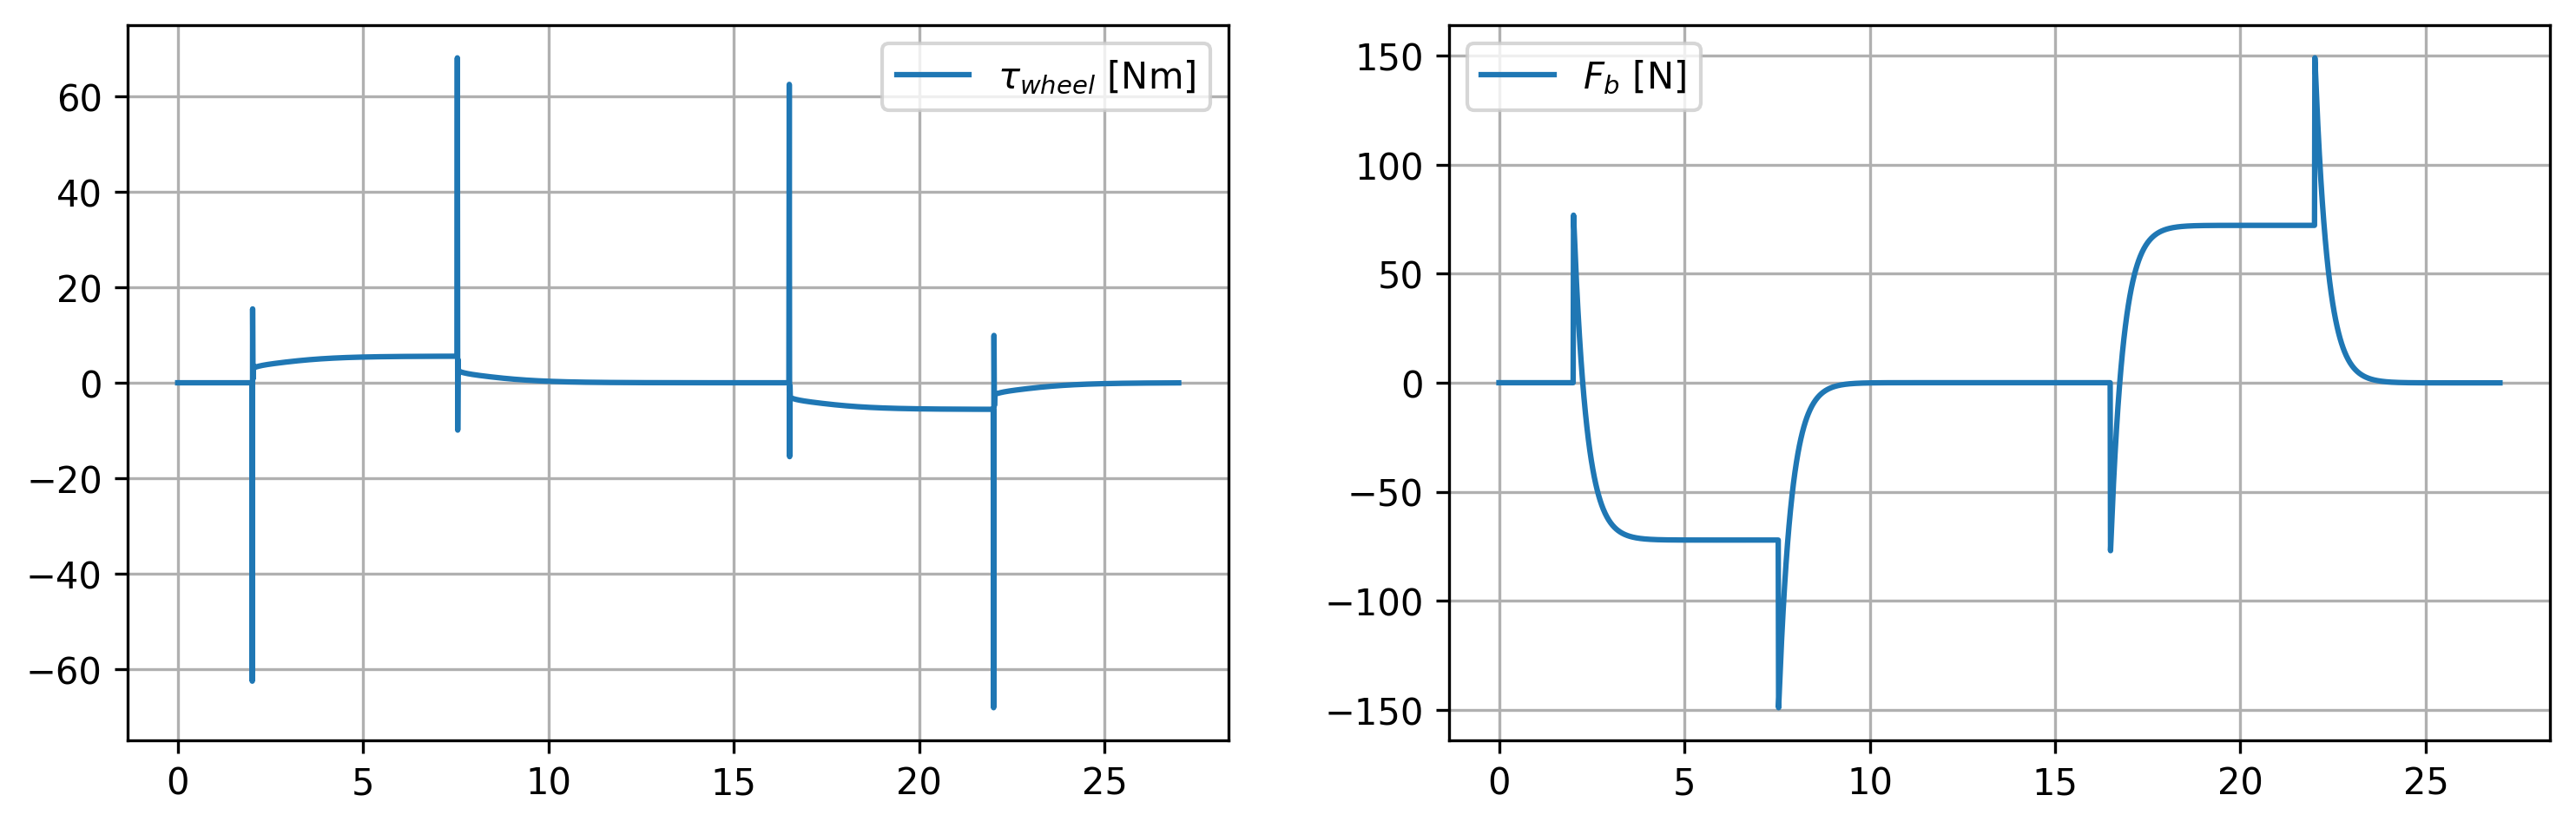

In [46]:
pl.figure(2, figsize=(12,8), dpi=300)


pl.subplot(221);
pl.plot(t_sim, u_sim[:,0]);
pl.legend([r'$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()

# pl.subplot(222);
# pl.plot(t_sim, u_sim[:,1]*0.8);
# pl.legend([r'$\tau_{body}$ [Nm]'], loc='best')
# pl.grid()

pl.subplot(222);
pl.plot(t_sim, u_sim[:,1]);
pl.legend([r'$F_b$ [N]'], loc='best')
pl.grid()

In [43]:
max(u_sim[:,0])

69.51895221031832

In [36]:
max(u_sim[:,1])

149.26751811017627